In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid", rc={'figure.figsize':(9,5)})

# Global stuff
df_boston = pd.read_csv('./data/boston_2015.csv', dtype={'start_station_id': np.int64, 'end_station_id': 'string', 'end_station_name': 'string', 'start_station_name': 'string', 'bike_id': np.int64, 'user_type': 'string'})
df_boston['start_time'] = pd.to_datetime(df_boston['start_time'], format='%Y-%m-%d %X')
df_boston['end_time'] = pd.to_datetime(df_boston['end_time'], format='%Y-%m-%d %X')
df_boston.drop(index=df_boston.loc[df_boston["end_station_id"] == "\\N"].index, inplace=True, axis=1)
days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

## General Overview of rentals per day over complete year

[Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Number of rides'),
 Text(0.5, 1.0, 'Rides per Day')]

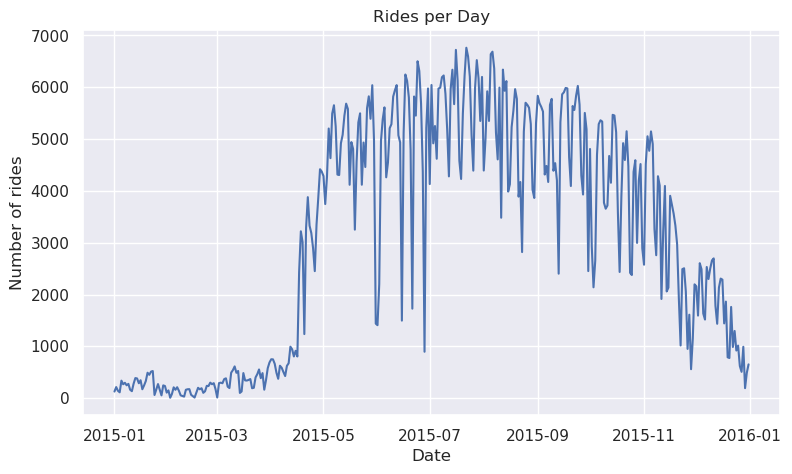

In [33]:
# Data
demand_series = df_boston.groupby(df_boston['start_time'].dt.date).size()
demand_series.index = pd.to_datetime(demand_series.index, format='%Y-%m-%d')

# Graph
ax = sns.lineplot(demand_series)
ax.set(xlabel='Date', ylabel='Number of rides', title='Rides per Day')


[Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Number of rides'),
 Text(0.5, 1.0, 'Rides per Week')]

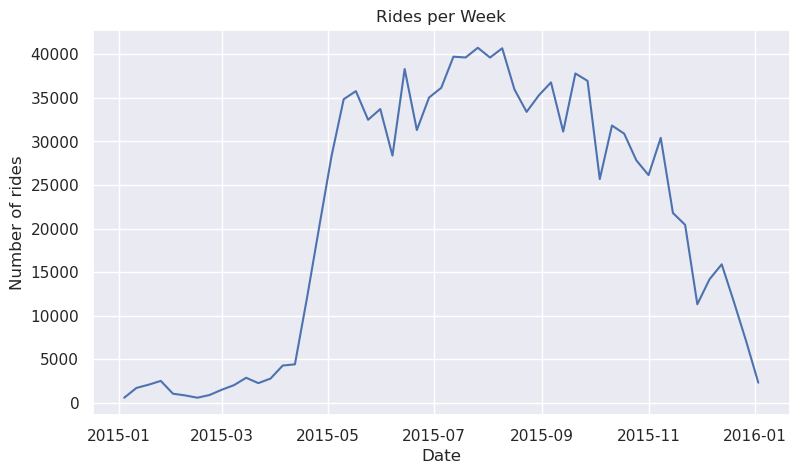

In [34]:
# Graph
ax = sns.lineplot(demand_series.resample('W').sum())
ax.set(xlabel='Date', ylabel='Number of rides', title='Rides per Week')

[Text(0.5, 0, 'Month of year 2015'),
 Text(0, 0.5, 'Number of rides'),
 Text(0.5, 1.0, 'Rides per Month')]

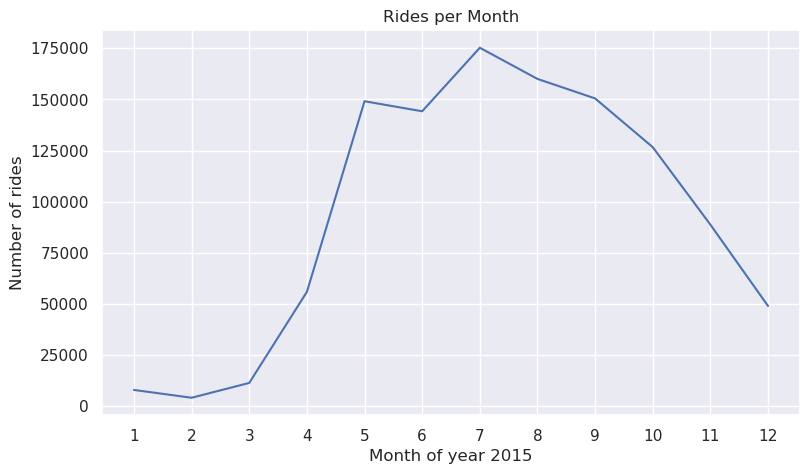

In [49]:
# Graph
demand_series_monthly = demand_series.resample('M').sum()
demand_series_monthly.index = list(range(1,13))
ax = sns.lineplot(demand_series_monthly)
ax.set_xticks(demand_series_monthly.index)
ax.set(xlabel='Month of year 2015', ylabel='Number of rides', title='Rides per Month')

## Rentals per weekday over complete year

[Text(0.5, 0, 'Weekday'),
 Text(0, 0.5, 'Number of rides'),
 Text(0.5, 1.0, 'Rides per Month')]

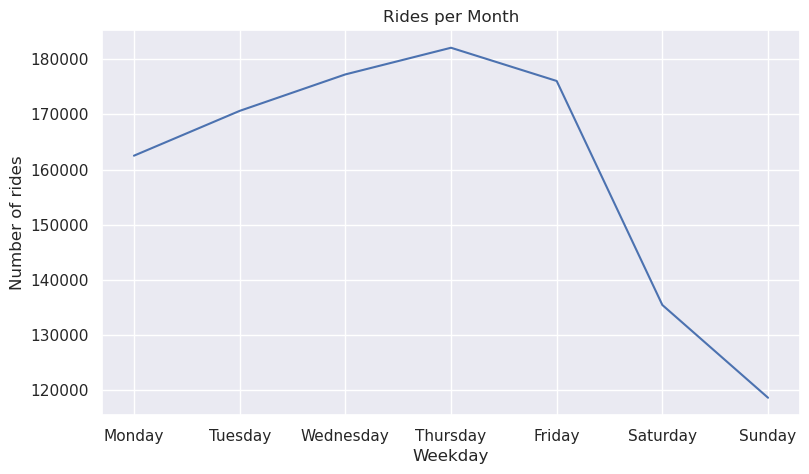

In [50]:
# Data
demand_weekday = df_boston.groupby(df_boston['start_time'].dt.day_name(), sort = True)
grouped_weekdays = demand_weekday.size().reindex(days)

# Graph
ax = sns.lineplot(grouped_weekdays)
ax.set_xticks(grouped_weekdays.index)
ax.set(xlabel='Weekday', ylabel='Number of rides', title='Rides per Month')

## Rentals per weekday over the year

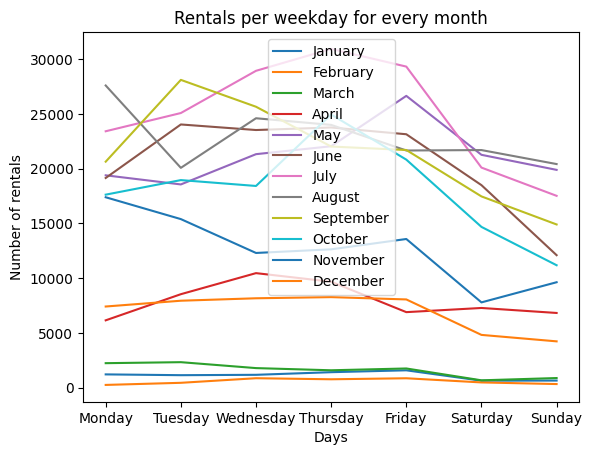

In [91]:
for i in range(1, 13):
    rentals_in_month = df_boston.loc[df_boston['start_time'].dt.month == i]
    demand_of_month_grouped_weekday = df_boston.groupby(rentals_in_month['start_time'].dt.day_name(), sort = True)
    plt.plot(demand_of_month_grouped_weekday.size().reindex(days), label=months[i-1])


plt.xlabel('Days')
plt.ylabel('Number of rentals')
plt.title('Rentals per weekday for every month')
plt.legend()
plt.show()